# Recommending a rate plan using Machine Learning

Mobile company Megaline is not satisfied to see that many of its customers are using inherited plans. They want to develop a model that can analyze customer's behavior and recommend one of Megaline's new plans: Smart or Ultra.

## Contents <a id='back'></a>

* [Intro](#intro)
* [Stage 1. Data loading and preprocessing](#data_review)
    * [1.1 Data exploration](#explore_data)
    * [1.2 Graphical data exploration](#graphical_explore)
* [Stage 2. Data division](#data_division)
* [Stage 3. Model analysis](#model_analysis)
    * [3.1 Decision tree](#decision_tree)
    * [3.2 Random forest](#random_forest)
    * [3.3 Logistic regression](#logistic_regression)
    * [3.4 Model comparison](#model_comparison)
* [Stage 4. Model quality](#model_quality)
    * [4.1 Decision tree](#decision_tree_quality)
    * [4.2 Random forest](#random_forest_quality)
    * [4.3 Logistic regression](#logistic_regression_quality)
* [Stage 5. Sanity test](#sanity_test)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

For this classification task we must create a model that chooses the right plan.

## Stage 1. Data loading and preprocessing <a id='data_review'></a>

In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [2]:
# Load the data files into DataFrame
try:
    df = pd.read_csv('/Users/vidam/Desktop/PRACTICUM/Proyecto_7/users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')

### 1.1 Data exploration <a id='explore_data'></a>

In [3]:
# printing the general/summary information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


The dataset contains the following fields:
- `сalls` — number of calls
- `minutes` — total duration of the call in minutes
- `messages` — number of text messages
- `mb_used` — Internet traffic used in MB
- `is_ultra` — plan for the current month (Ultra = 1, Smart = 0)

In [4]:
df.duplicated().sum()

0

In [5]:
df.describe().astype('int')

,calls,minutes,messages,mb_used,is_ultra
count,3214,3214,3214,3214,3214
mean,63,438,38,17207,0
std,33,234,36,7570,0
min,0,0,0,0,0
25%,40,274,9,12491,0
50%,62,430,30,16943,0
75%,82,571,57,21424,1
max,244,1632,224,49745,1


In [6]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


So, df is a 3214 rows and 5 columns dataframe with no null values, no duplicated rows and apparently no unusual values inside it. Types of columns is coherent with their info.

### 1.2 Graphical data exploration <a id='graphical_explore'></a>

In order to be better aware of what the data include, lets run a graphical data exploration.

For features ('calls', 'minutes', 'messages', 'mb_used') we will plot some histograms. For the target, a bar chart would do the job. Finally, in order to relate the features to the target, we make some boxplot.

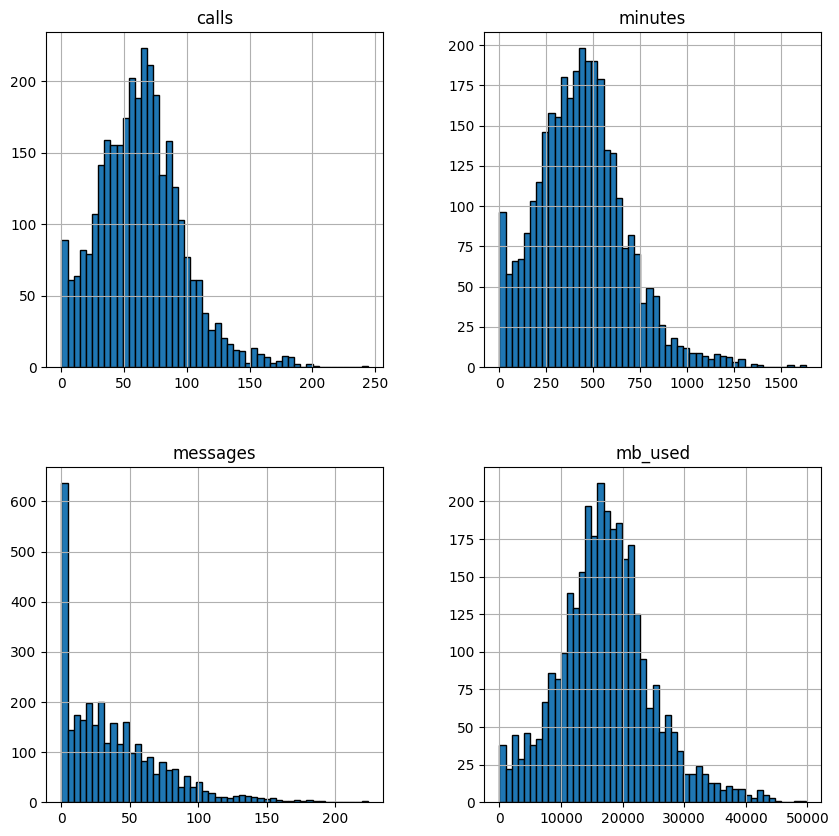

In [7]:
df.hist(['calls', 'minutes', 'messages', 'mb_used'] ,bins=50, edgecolor = 'black', figsize=(10,10))
plt.show()

So, generally speaking, most of the customers have around 70 calls per month, spend around 400 minutes calling, send no messages and use around 17000 mb

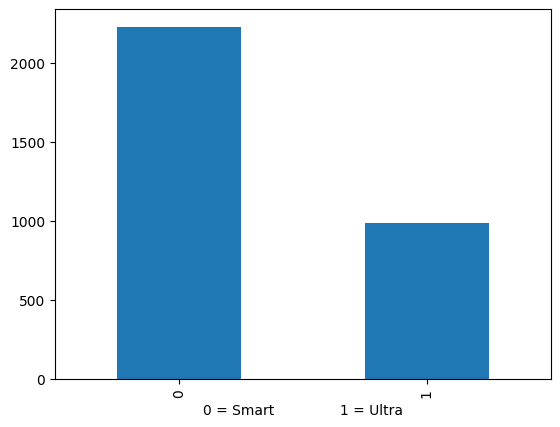

In [8]:
df['is_ultra'].value_counts().plot(kind='bar')
plt.xlabel('0 = Smart               1 = Ultra')
plt.show()

Most of users use 'Smart' option.

And now, as said above, in order to relate the features to the target, we make some boxplot.

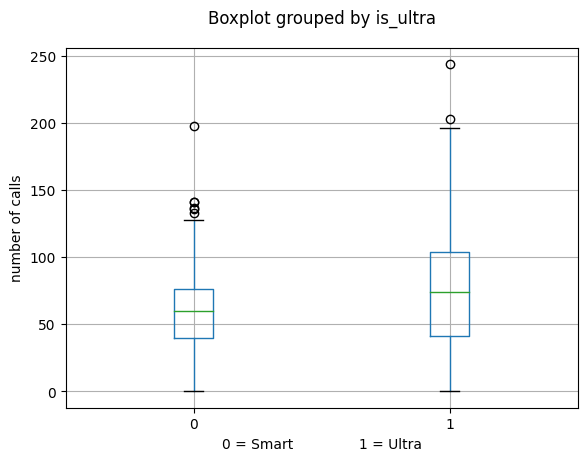

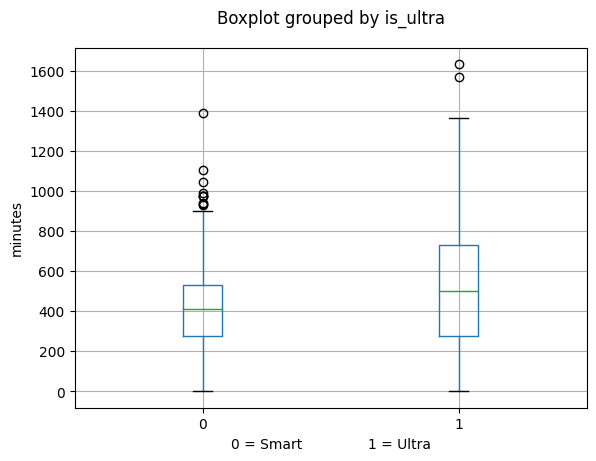

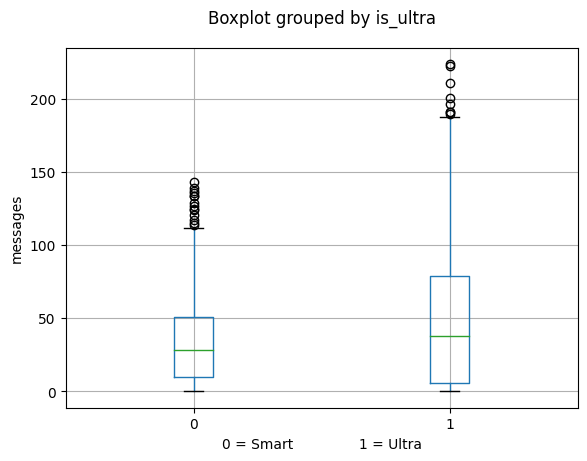

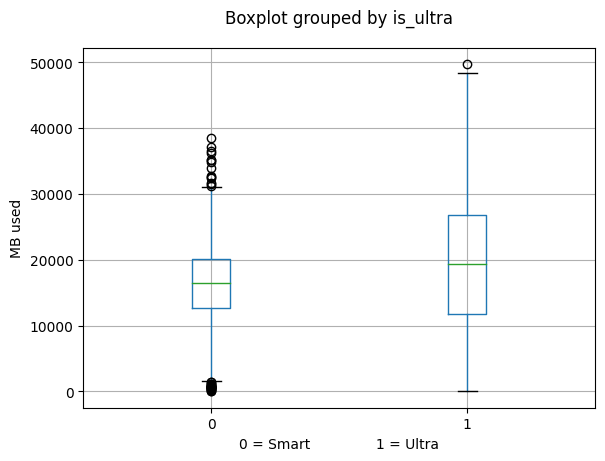

In [9]:
df.boxplot(column='calls', by='is_ultra')
plt.title('')
plt.xlabel('0 = Smart               1 = Ultra')
plt.ylabel('number of calls')

df.boxplot(column='minutes', by='is_ultra')
plt.title('')
plt.xlabel('0 = Smart               1 = Ultra')
plt.ylabel('minutes')

df.boxplot(column='messages', by='is_ultra')
plt.title('')
plt.xlabel('0 = Smart               1 = Ultra')
plt.ylabel('messages')

df.boxplot(column='mb_used', by='is_ultra')
plt.title('')
plt.xlabel('0 = Smart               1 = Ultra')
plt.ylabel('MB used')

plt.show()

First thing that jumps to the eyes is that 'Smart' plan has many more outliers, especially if we look at messages. Other important characteristic is that median values of both plan are pretty close between them.

## Stage 2. Data division <a id='data_division'></a>

What we are going to do now is splitting our dataframe (source data) in 3 sets:
- training set (3/5 of our data)
- validation set (1/5 of our data)
- test set (1/5 of our data)

Since a multiple split is not possible, we will do 2 steps of splitting. First one is between df_train and df_valid with a 60/40 rule and second one is between df_valid and df_test with a 50/50 rule. This means that at the end, the original dataframe is splitted df_train 60%, df_valid 20% and df_test 20%

In [10]:
# Splitting training set from validation set (60/40)
df_train, df_valid = train_test_split(df, test_size = 0.40, random_state=12345)

In [11]:
# Splitting validation set from test set (50/50)
df_valid, df_test = train_test_split(df_valid, test_size = 0.50, random_state=12345)

In [12]:
print('Size of the training set "df_train" is:', df_train.shape)
print('Size of the validation set "df_valid" is:', df_valid.shape)
print('Size of the test set "df_test" is:', df_valid.shape)

Size of the training set "df_train" is: (1928, 5)
Size of the validation set "df_valid" is: (643, 5)
Size of the test set "df_test" is: (643, 5)


Now we declare variables for the features and targets for both training set "df_train" and validation set "df_valid":

In [13]:
# Declaring variables for training set
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

In [14]:
# Declaring variables for validation set
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

So, in the features variables we have all columns less "is_ultra" while in target variables we have only "is_ultra" column.

## Stage 3. Model analysis <a id='model_analysis'></a>

Now we investigate the quality of different models by changing their hyperparameters. Since
our task is a binary classification (meaning only two possible answers), the models we want to compare are:
- Decision tree
- Random forest
- Logistic regression

We look for an accuracy of at least 0.75.

### 3.1 Decision tree <a id='decision_tree'></a>

With decision tree models, to get the highest accuracy, we need to iterate through different tree depth options in the training algorithm.

In [15]:
tree_dep = []
tree_acc = []

for depth in range(1, 11):
        model_tree = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
        model_tree.fit(features_train, target_train)
        predictions_valid_tree = model_tree.predict(features_valid)
        score = accuracy_score(target_valid, predictions_valid_tree)
        tree_dep.append(depth)
        tree_acc.append(score)
        print("max_depth:", depth, ", Accuracy:", score)

max_depth: 1 , Accuracy: 0.7542768273716952
max_depth: 2 , Accuracy: 0.7822706065318819
max_depth: 3 , Accuracy: 0.7853810264385692
max_depth: 4 , Accuracy: 0.7791601866251944
max_depth: 5 , Accuracy: 0.7791601866251944
max_depth: 6 , Accuracy: 0.7838258164852255
max_depth: 7 , Accuracy: 0.7822706065318819
max_depth: 8 , Accuracy: 0.7791601866251944
max_depth: 9 , Accuracy: 0.7822706065318819
max_depth: 10 , Accuracy: 0.7744945567651633


To have a better view, let's plot a graph:

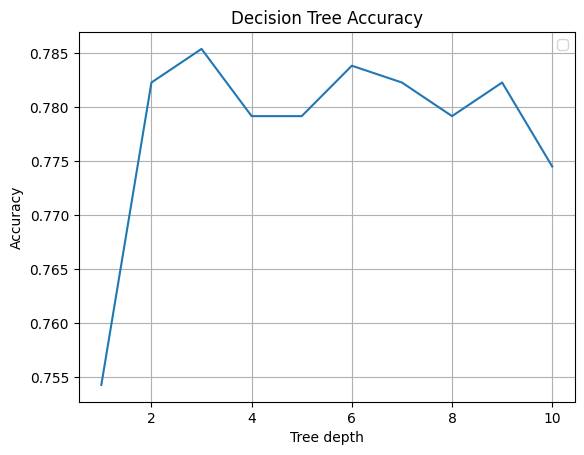

In [16]:
sns.lineplot(data = pd.DataFrame(data = tree_acc, index = tree_dep))
plt.title('Decision Tree Accuracy') 
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.legend('')
plt.grid()
plt.show()

The most important hyperparameter of a decision tree is max_depth. The previous iteration shows us that when max_depth is 3 the accuracy is best: 0.785

### 3.2 Random forest <a id='random_forest'></a>

Another learning algorithm is called random forest. This algorithm trains a large number of independent trees and makes a decision by voting. A random forest helps to improve the results and avoid overfitting.

We use the hyperparameter n_estimators (stands for "number of estimators") to set the number of trees in the forest.

In [17]:
forest_tree_num = []
forest_acc = []
tree_dep = []

best_score = 0
best_est = 0
best_depth = 0

for est in range(10, 101, 10):
        for depth in range(1, 5):
                model_forest = RandomForestClassifier(random_state = 12345, n_estimators= est, max_depth=depth)
                model_forest.fit(features_train, target_train)
                predictions_valid_forest = model_forest.predict(features_valid)
                score = accuracy_score(target_valid, predictions_valid_forest)
                forest_tree_num.append(est)
                forest_acc.append(score)
                tree_dep.append(depth)
                print("max_depth:", depth, ", Estimator:", est, ", Accuracy:", score)
                print()
                if score > best_score:
                        best_score = score
                        best_est = est
                        best_depth = depth
                
print('Best model with RandomForestClassifier is with {} trees , max-depth = {} and accuracy = {}'.format(best_est, best_depth, best_score))              

max_depth: 1 , Estimator: 10 , Accuracy: 0.7558320373250389

max_depth: 2 , Estimator: 10 , Accuracy: 0.7776049766718507

max_depth: 3 , Estimator: 10 , Accuracy: 0.7853810264385692

max_depth: 4 , Estimator: 10 , Accuracy: 0.7900466562986003

max_depth: 1 , Estimator: 20 , Accuracy: 0.7667185069984448

max_depth: 2 , Estimator: 20 , Accuracy: 0.7838258164852255

max_depth: 3 , Estimator: 20 , Accuracy: 0.7869362363919129

max_depth: 4 , Estimator: 20 , Accuracy: 0.7884914463452566

max_depth: 1 , Estimator: 30 , Accuracy: 0.7667185069984448

max_depth: 2 , Estimator: 30 , Accuracy: 0.7838258164852255

max_depth: 3 , Estimator: 30 , Accuracy: 0.7869362363919129

max_depth: 4 , Estimator: 30 , Accuracy: 0.7869362363919129

max_depth: 1 , Estimator: 40 , Accuracy: 0.776049766718507

max_depth: 2 , Estimator: 40 , Accuracy: 0.7853810264385692

max_depth: 3 , Estimator: 40 , Accuracy: 0.7869362363919129

max_depth: 4 , Estimator: 40 , Accuracy: 0.7900466562986003

max_depth: 1 , Estimator:

To have a better view, let's plot a graph:

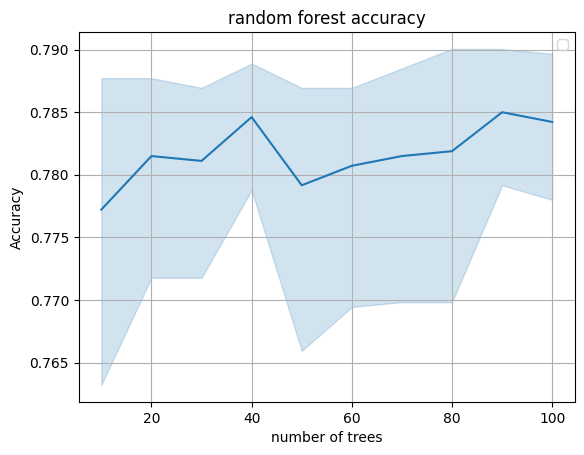

In [18]:
sns.lineplot(data = pd.DataFrame(data = forest_acc, index = forest_tree_num))
plt.title('random forest accuracy') 
plt.xlabel('number of trees')
plt.ylabel('Accuracy')
plt.legend('')
plt.grid()
plt.show()

The most important hyperparameter of a random forest is number of estimators (meaning number of trees). Anyway, models based on trees still remain dependant on the depth of this. The previous iteration shows us that when number of trees is 80 and the max-depth is 4 the accuracy is best: 0.791

### 3.3 Logistic regression <a id='logistic_regression'></a>

In [19]:
model_regress = LogisticRegression(random_state = 12345, solver='liblinear')
model_regress.fit(features_train, target_train)
predictions_valid_reg = model_regress.predict(features_valid)
# score = accuracy_score(target_valid, predictions_valid_reg) # same of 'score_valid'
score_train = model_regress.score(features_train, target_train)
score_valid = model_regress.score(features_valid, target_valid)

print('score_train:', score_train)
print('score_valid:', score_valid)

score_train: 0.7157676348547718
score_valid: 0.7091757387247278


This model is slightly overfitted because score_train is larger than score_valid.

### 3.4 Model comparison <a id='model_comparison'></a>

Lets now plot all three models with their accuracies in one single chart:

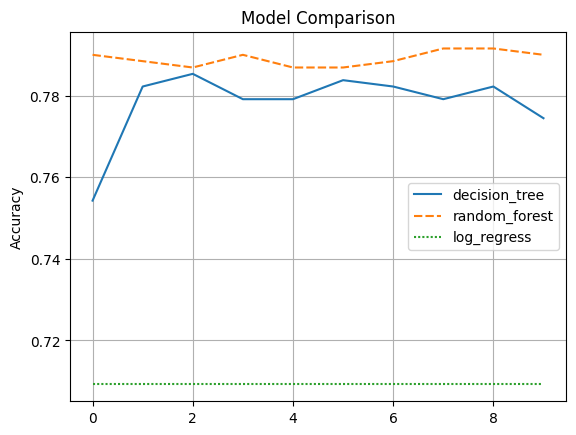

In [20]:
data = pd.DataFrame(columns=['decision_tree', 'random_forest', 'log_regress'])
data['decision_tree'] = tree_acc
data['random_forest'] = forest_acc[3:40:4]
data['log_regress'] = score_valid

sns.lineplot(data = data)
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

So, we can conclude that in our case, Random Forest is the best model to choose

## Stage 4. Model quality <a id='model_quality'></a>

To test if our model makes accurate predictions even when faced with new data, we are going to use a new data set. That will be df_test.

In [21]:
# Declaring variables for test set
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

### 4.1 Decision tree <a id='decision_tree_quality'></a>

In [22]:
predictions_test_tree = model_tree.predict(features_test)

def error_count(answers, predictions):
    counter=0
    for i in range(len(target_test)):
        if answers[i] != predictions[i]:
            counter+=1
    return counter

def accuracy(answers, predictions):
    correct = 0
    for i in range(len(answers)):
        if answers[i] == predictions[i]:
            correct+=1
    return correct / len(answers) 


print('Errors:', error_count(target_test.values, predictions_test_tree), 'over', len(target_test), 'observations')
print('Accuracy:', accuracy(target_test.values, predictions_test_tree))

Errors: 136 over 643 observations
Accuracy: 0.7884914463452566


### 4.2 Random forest <a id='random_forest_quality'></a>

In [23]:
predictions_test_forest = model_forest.predict(features_test)

print('Errors:', error_count(target_test.values, predictions_test_forest), 'over', len(target_test), 'observations')
print('Accuracy:', accuracy(target_test.values, predictions_test_forest))

Errors: 139 over 643 observations
Accuracy: 0.7838258164852255


### 4.3 Logistic regression <a id='logistic_regression_quality'></a>

In [24]:
predictions_test_regr = model_regress.predict(features_test)

print('Errors:', error_count(target_test.values, predictions_test_regr), 'over', len(target_test), 'observations')
print('Accuracy:', accuracy(target_test.values, predictions_test_regr))

Errors: 200 over 643 observations
Accuracy: 0.6889580093312597


So, the Decisiom Tree model result to be the most precise with df_test (136 errors over 643 cases) while the logistic regression is the least (200 errors over 643 cases)

## Stage 5. Sanity test <a id='sanity_test'></a>

A sanity test aims to make sure that our model performs better than pure casuality.
Since, in our case, there are two possible answers (1 for Ultra plan and 0 for Smart plan), lets suppose to have a model that assigns "0" or "1" randomly.

We use DummyClassifier that makes predictions that ignore the input features.

In [25]:
X = df.drop(['is_ultra'], axis=1)
y = df['is_ultra']
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X, y)

In [26]:
print('Accuracy of the random responses:', dummy_clf.score(X, y))
print('Accuracy of the model DecisionTreeClassifier', accuracy(target_test.values, predictions_test_tree))
print('Accuracy of the model RandomForestClassifier', accuracy(target_test.values, predictions_test_forest))
print('Accuracy of the model Logistic regression', accuracy(target_test.values, predictions_test_regr))

Accuracy of the random responses: 0.693528313627878
Accuracy of the model DecisionTreeClassifier 0.7884914463452566
Accuracy of the model RandomForestClassifier 0.7838258164852255
Accuracy of the model Logistic regression 0.6889580093312597


As seen before, for all 3 models we used, the accuracy is above 0.69 and so we can confirm that our models pass the sanity test.

## Conclusion <a id='conclusion'></a>

We started our project with the aim of developing a model that could analyze customer behavior and recommend one of Megaline's new plans: Smart or Ultra. 

Megaline provided us with a 3214 observations and 5 features dataframe. Among the 5 features, one of them is a target (Is_ultra).

First step was to load and verify our data. Everything seemed fine.

After that we split the original dataframe in 3 set: training, validation and test set with a 60/20/20 rule

We run a model analysis, investigating how the accuracies of the three models change with different hyperparameters.

We evaluated the quality of the models (decision tree, random forest and logistic regression) and we realized that, for df_test, decision tree is the most accurate.

Finally we ran a sanity check and realized that all our models pass it.